In [145]:
%pylab inline

from scipy import stats
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import expit
from datetime import datetime, timedelta
from scipy.signal import windows


Populating the interactive namespace from numpy and matplotlib


In [141]:
def est_poission_rate_ci(n_events, 
                         source_duration, 
                         target_duration=1.0, 
                         ci=0.98,
                         expected_avg_n_events_per_unit_duration=200):
    """
    Estimate poission rate parameter confidence interval

    Parameters
    ----------
    n_events : int
        number of observed events
    source_duration : float
        duration for which n_events were observed
    target_duration : float
        duration for which to return expected rate
    ci : float
        size of confidence interval

    Returns
    -------
    (float,float)
        Confidence interval left, right bounds
    """
    
    def calc_posterior(prior_shape, prior_scale, n_events, duration):
        posterior_shape = prior_shape + n_events
        posterior_scale = prior_scale/(prior_scale*duration+1)

        return posterior_shape, posterior_scale

    rate_prior_average = expected_avg_n_events_per_unit_duration
    rate_prior_shape = 1
    rate_prior_scale = rate_prior_average/rate_prior_shape
    rate_prior = stats.gamma(rate_prior_shape,scale=rate_prior_scale)
    
    posterior_shape, posterior_scale = calc_posterior(rate_prior_shape, 
                                                      rate_prior_scale, 
                                                      n_events, 
                                                      source_duration/target_duration)
    posterior = stats.gamma(posterior_shape,scale=posterior_scale)
    return posterior

In [205]:
def desp(obs):
    alphas = [0.496] #496
    t = 2
    sqt_prev = 0
    sqt2_prev = 0
    for alpha in alphas: 
        exp_rate = []
        for p in obs:
            f = alpha * t / (1 - alpha)
            sqt_x = (alpha * p) + ((1 - alpha) * sqt_prev)
            sqt2_x = (alpha * sqt_x) + ((1 - alpha) * sqt2_prev)
            pred_x = (2 + f) * sqt_x - (1 + f) * sqt2_x
            if pred_x < 0:
                result = 0 
            else:
                result = np.array(pred_x)
            sqt_prev = np.array(sqt_x)
            sqt2_prev = np.array(sqt2_x)
            exp_rate.append(result)  

    exp_rate = np.array(exp_rate)
    return exp_rate

def runner_desp(df):
        df = df.dropna()
        obs = df['obs_n_events'].to_numpy()
        
        exp_rate = np.array(desp(obs))
        df['exp_rate'] = exp_rate
        return df

In [144]:
def make_lognorm(mean,std):
    # Creates lognormal distribution with specific mean and standard deviation
    shape = np.sqrt(np.log((std**2 + mean**2)/mean**2))
    scale = (mean**3 * np.sqrt((std**2 + mean**2)/mean**2))/(std**2 + mean**2)
    return stats.lognorm(shape,scale=scale)

In [194]:
# Find lower bound for specific confidence interval
def find_lower_ci(df,risk_premium):
    exp_rate = np.array(df['exp_rate'])
    #exp_rate = exp_rate.reshape((len(exp_rate), 1))        
    lower_ci = np.array(([(rate * (1+risk_premium)) for rate in exp_rate]))
    df['lower_ci'] = lower_ci
    return df


def is_outlier(df):

    # lower_ci - Any rate below lower_ci is an outlier
    # Observed rate estimated from observations
    obs_n_events = np.array(df['obs_n_events'])
    lower_ci = np.array(df['lower_ci'])

    obs_rate = np.array(([est_poission_rate_ci(obs,1) for obs in obs_n_events]))
    is_outlier = np.array(([ 0 if (rate.cdf(ci) > 0.99) else 1 for rate,ci in zip(obs_rate, lower_ci) ]))

    df['yhat'] = is_outlier

    return df

In [146]:
def seasionality(x,shape=1,strength=1): # Seasonality function with period '1' with variable strength and shape
    s = expit( np.sin(x*np.pi*2) * shape )*2
    return ((s-1) * strength)+1

def simulate_expected_by_minute(n_days):
    minutes = np.arange(0,n_days*24*60)
    hours = minutes/60
    days = hours/24
    weeks = days/7
    months = days/30
    quarter = days/(365/4)
    
    # Hour random fluctuations
    hour_random_x = np.arange( np.floor(hours.min())-1, np.ceil(hours.max())+1 )
    hour_random_x = hour_random_x + np.random.uniform(-0.5,0.5,size=len(hour_random_x))
    hour_random_f1 = np.random.uniform(0.95,1.05,size=len(hour_random_x))
    hour_random_f2 = np.random.uniform(0.5,1.5,size=len(hour_random_x))
    hour_random1 = np.interp(hours,hour_random_x,hour_random_f1)
    hour_random2 = np.interp(hours,hour_random_x,hour_random_f2)
    
    # Simulation random parameters
    avg_bookings_per_hour = np.exp(np.random.uniform(0,6))
    
    daily_seasonality_shift = np.random.uniform(-1,1)
    daily_seasonality_strength = np.random.uniform(0,1)
    daily_seasonality_shape = np.random.uniform(1,10)
    
    weekly_seasonality_shift = np.random.uniform(-1,1)    
    weekly_seasonality_strength = np.random.uniform(0,0.5)
    weekly_seasonality_shape = np.random.uniform(0,2)
    
    monthly_seasonality_shift = np.random.uniform(-1,1)    
    monthly_seasonality_strength = np.random.uniform(0,0.5)
    monthly_seasonality_shape = np.random.uniform(0,2)
    
    quarterly_seasonality_shift = np.random.uniform(-1,1)    
    quarterly_seasonality_strength = np.random.uniform(0,0.5)
    quarterly_seasonality_shape = np.random.uniform(0,2)
    
    exp_rate = np.ones(len(minutes)) * avg_bookings_per_hour/60
    exp_rate_seasoned = (
        exp_rate
        # * hour_random1
        * seasionality(days+daily_seasonality_shift,daily_seasonality_shape,daily_seasonality_strength)
        * seasionality(weeks+weekly_seasonality_shift,weekly_seasonality_shape,weekly_seasonality_strength)
        * seasionality(months+monthly_seasonality_shift,monthly_seasonality_shape,monthly_seasonality_strength)
        * seasionality(quarter+quarterly_seasonality_shift,quarterly_seasonality_strength,quarterly_seasonality_shape)
    )
    exp_rate_std = exp_rate_seasoned * np.random.uniform(0.03,0.5)
    exp_rate_std = exp_rate_std * hour_random2
    
    # Create anomalies
    anomaly_mult = np.ones(len(minutes))
    
    anomaly_duration_min = 5 # 5 minutes
    anomaly_duration_max = 7*24*60 # 1 week
    anomaly_increase_proba = 0.1
    
    anomaly_max_frac = 0.3
    
    anomalies = list()
    
    for i in range(100):
        if np.mean(anomaly_mult != 1) > anomaly_max_frac:
            break
        anomaly_start = np.random.choice(minutes)
        anomaly_duration_minutes = int(np.round(np.exp(np.random.uniform(np.log(5),np.log(7*24*60)))))
        anomaly_end = anomaly_start+anomaly_duration_minutes
        if anomaly_end >= len(minutes):
            continue
        if np.random.uniform(0,1) < 0.1:
            anomaly_coef = np.random.uniform(1.01,1.1)
        else:
            anomaly_coef = (1-np.exp(np.random.uniform(np.log(1),np.log(100)))/100)
        if np.min(anomaly_mult[anomaly_start:anomaly_end]) != 1:
            continue
            
        # 'Impact' is approximation of how many bookings were 'missed'
        impact = (exp_rate[anomaly_start:anomaly_end] * (1-anomaly_coef)).sum()
            
        anomalies.append({
            'start': anomaly_start,
            'end': anomaly_end,
            'coef': anomaly_coef,
            'impact': impact,
        })
        
        anomaly_mult[anomaly_start:anomaly_end] *= anomaly_coef
    
    return minutes, exp_rate_seasoned, exp_rate_std, anomaly_mult, anomalies

def make_lognorm(mean,std):
    # Creates lognormal distribution with specific mean and standard deviation
    shape = np.sqrt(np.log((std**2 + mean**2)/mean**2))
    scale = (mean**3 * np.sqrt((std**2 + mean**2)/mean**2))/(std**2 + mean**2)
    return stats.lognorm(shape,scale=scale)

def simulate_bookings_minute(exp_rate,exp_rate_std):
    # Assuming our "true" rate is distributed log-normally relative to our expected rate
    rate = make_lognorm(exp_rate,exp_rate_std).rvs()
    return rate, stats.poisson(rate).rvs()

def make_test_dataframe(n_days=30):
    # Create dataframe
    minute, expected_rate, exp_rate_std, anomaly_coef, anomalies = simulate_expected_by_minute(n_days)
    exp_rate_ci_min, exp_rate_ci_max = make_lognorm(expected_rate, exp_rate_std).interval(0.98)
    
    # Create observed rate with anomalies and events
    anomaly_rate = expected_rate * anomaly_coef
    anomaly_rate_std = exp_rate_std * anomaly_coef
    true_rate, n_events = simulate_bookings_minute(anomaly_rate,anomaly_rate_std)
    
    start_dttm = datetime(2022,1,10)
    def minute_to_dttm(minute):
        return start_dttm + timedelta(minutes=int(minute))
        
    
    anomalies = pd.DataFrame(anomalies)
    anomalies['start'] = anomalies['start'].map(minute_to_dttm)
    anomalies['end'] = anomalies['end'].map(minute_to_dttm)
    anomalies['duration'] = anomalies['end'] - anomalies['start']
    anomalies = anomalies.sort_values('start').reset_index(drop=True)
    
    
    data = pd.DataFrame({
        'minute': minute,
        'hour': minute//60,
        'day': minute//60//24,
        'week': minute//60//24//7,
        'dttm': map(minute_to_dttm,minute),
        'expected_rate': expected_rate,
        'expected_rate_std': exp_rate_std,
        'exp_rate_ci_min': exp_rate_ci_min,
        'exp_rate_ci_max': exp_rate_ci_max,
        'true_rate': true_rate,
        'anomaly_coef': anomaly_coef,
        'obs_n_events': n_events
    }).set_index('dttm')
    return data, anomalies

In [239]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def pred(df, df_test):
    # Multiplicative trend / Additive seasonality model
    model_mul_add = ExponentialSmoothing(df['obs_n_events'], trend='mul', seasonal='add', seasonal_periods=2)
    results_mul_add = model_mul_add.fit()
    predictions_mul_add = results_mul_add.forecast(steps=1)

    # Multiplicative trend / Multiplicative seasonality model
    model_mul_mul = ExponentialSmoothing(df['obs_n_events'], trend='mul', seasonal='mul', seasonal_periods=2)
    results_mul_mul = model_mul_mul.fit()
    predictions_mul_mul = results_mul_mul.forecast(steps=1)

    # Evaluate
    rmse_mul_add = mean_squared_error(df_test['obs_n_events'], predictions_mul_add, squared=False)
    rmse_mul_mul = mean_squared_error(df_test['obs_n_events'], predictions_mul_mul, squared=False)

    # Plot
    plt.title(f'obs_n_events Triple Exponential Smoothing predictions\nRMSE (mul, add) = {np.round(rmse_mul_add, 2)} | RMSE (mul, mul) = {np.round(rmse_mul_mul, 2)}', size=20)
    plt.plot(df['obs_n_events'], label='Training data')
    plt.plot(df_test['obs_n_events'], color='gray', label='Testing data')
    plt.plot(predictions_mul_add, color='orange', label='Predictions Multiplicative trend, Additive seasonality')
    plt.plot(predictions_mul_mul, color='red', label='Predictions Multiplicative trend, Multiplicative seasonality')
    plt.legend();


# Experiment

In [159]:
data, anomalies = make_test_dataframe(n_days=50)
data.head()

,minute,hour,day,week,expected_rate,expected_rate_std,exp_rate_ci_min,exp_rate_ci_max,true_rate,anomaly_coef,obs_n_events
dttm,,,,,,,,,,,
2022-01-10 00:00:00,0,0,0,0,0.198721,0.086864,0.068834,0.481664,0.200519,1.0,0
2022-01-10 00:01:00,1,0,0,0,0.198720,0.086024,0.069538,0.478259,0.145263,1.0,1
2022-01-10 00:02:00,2,0,0,0,0.198719,0.085184,0.070250,0.474862,0.169234,1.0,0
2022-01-10 00:03:00,3,0,0,0,0.198718,0.084344,0.070970,0.471476,0.160039,1.0,0
2022-01-10 00:04:00,4,0,0,0,0.198717,0.083504,0.071698,0.468101,0.180071,1.0,0


In [157]:
data_hourly = data.groupby('hour')[['anomaly_coef',
                      'obs_n_events']].sum()
data_hourly['anomaly_coef'] = data_hourly['anomaly_coef']/60
data_hourly

,anomaly_coef,obs_n_events
hour,,
0,1.0,7
1,1.0,4
2,1.0,7
3,1.0,4
4,1.0,5
...,...,...
1195,1.0,3
1196,1.0,7
1197,1.0,3


In [214]:
df_h = runner_desp(data_hourly)
df_h = find_lower_ci(df_h, 0.5)
df_h = is_outlier(df_h)


df_h

,anomaly_coef,obs_n_events,exp_rate,lower_ci,yhat
hour,,,,,
0,1.0,7,8.666112,12.999168,1
1,1.0,4,6.743505,10.115257,1
2,1.0,7,9.294234,13.941351,1
3,1.0,4,5.663694,8.495540,1
4,1.0,5,5.570199,8.355299,1
...,...,...,...,...,...
1195,1.0,3,2.882511,4.323766,1
1196,1.0,7,7.591977,11.387966,1
1197,1.0,3,3.690557,5.535836,1


In [212]:
ytrue = np.array(([1 if (1 == coef) else 0 for coef in df_h['anomaly_coef']]))
df_h['ytrue'] = ytrue

In [238]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

seq_train = df_h[:1]
seq_test = df_h[1:2]
pred(seq_train, seq_test)


ValueError: seasonal_periods must be larger than 1.

Populating the interactive namespace from numpy and matplotlib


/opt/homebrew/Caskroom/miniforge/base/envs/bigq/lib/python3.10/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


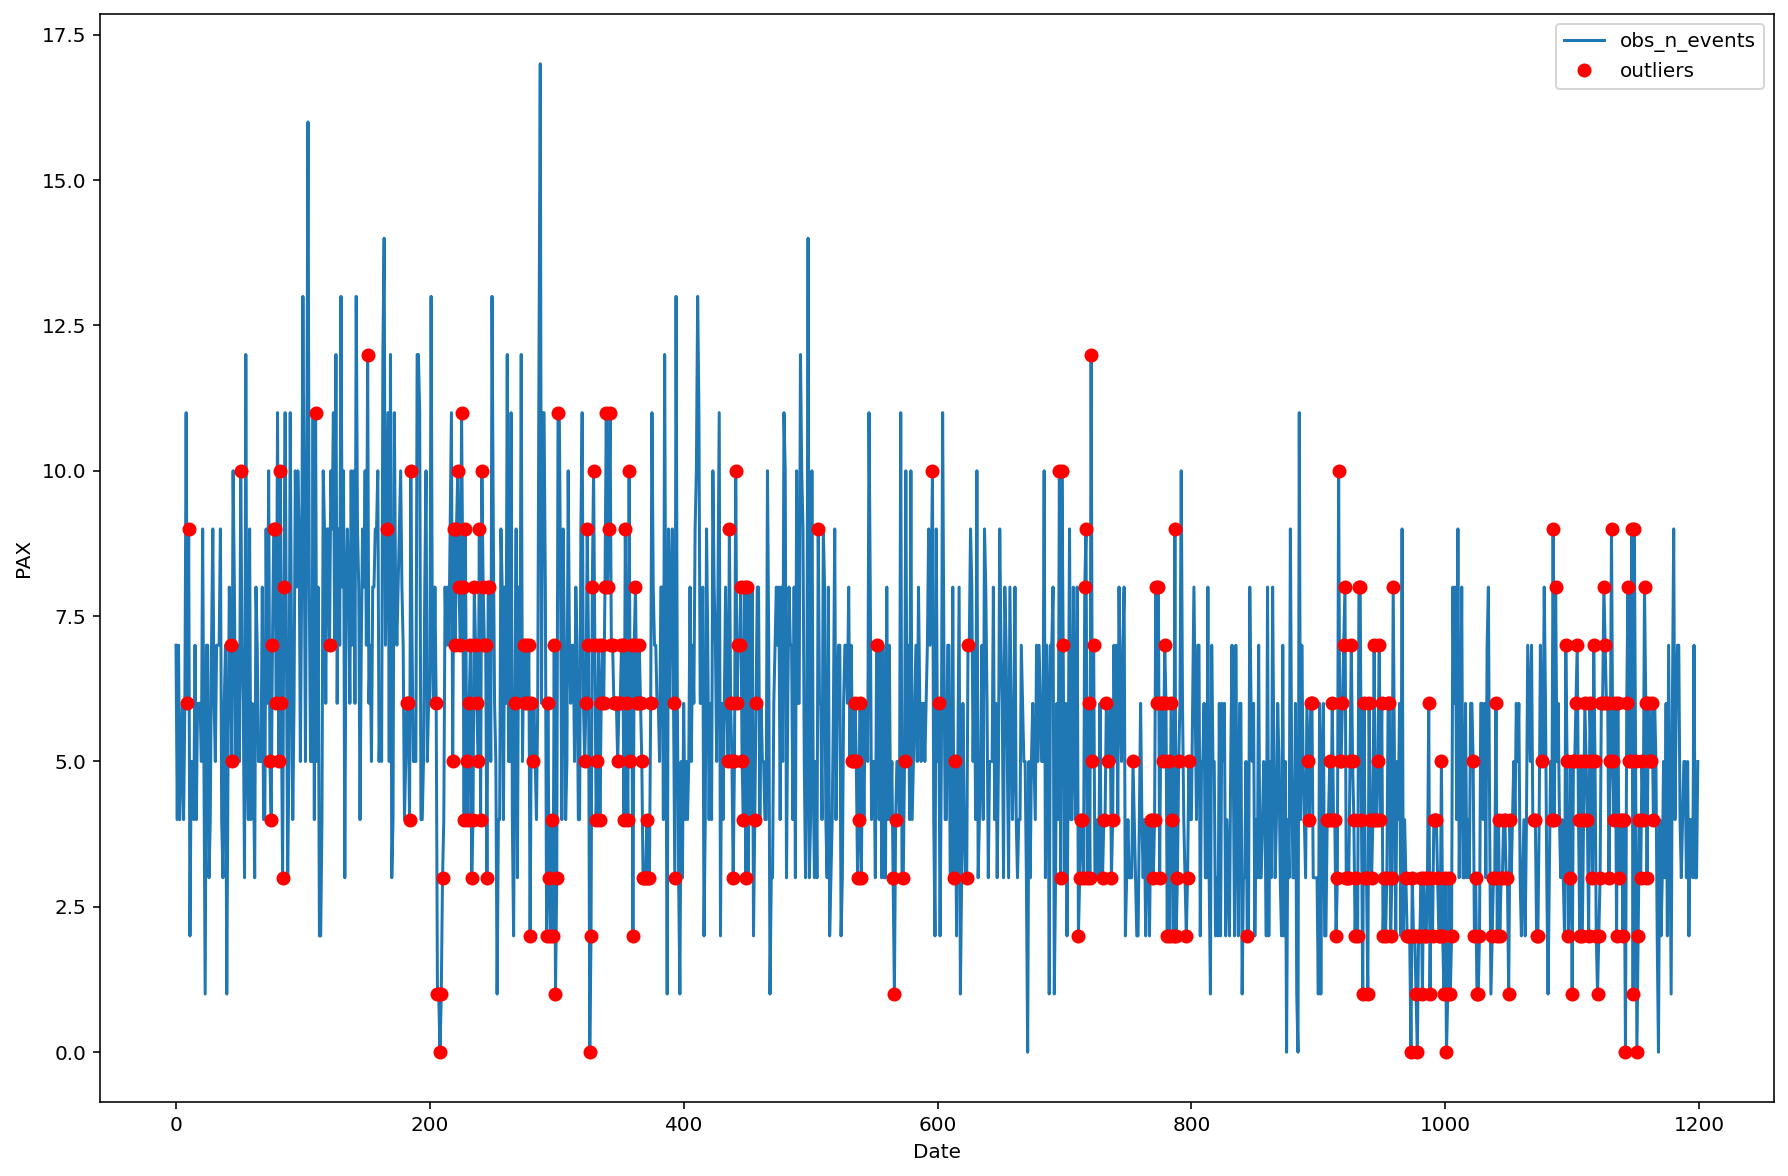

In [202]:
%pylab inline
%config InlineBackend.figure_format='retina'
import pandas as pd


res = df_h.copy()
res['ytrue'] = (res['ytrue'] == 0)
#res['booking_dttm'] = pd.to_datetime( res.apply(lambda x: str(x['booking_date'])+'T'+f"{x['booking_hour']:0>2}:00:00",axis=1) )
#res = res.set_index('booking_dttm').sort_index()
#res = res[-150:]

figsize(15,10)
res['obs_n_events'].plot(color='C0')
res[res['ytrue']]['obs_n_events'].plot(ls='',marker='o',color='r',label='outliers')
#res['exp_pax_w1'].plot(color='k',alpha=0.2,ls='-.',marker='x',label='past weeks')
#res['exp_pax_w2'].plot(color='k',alpha=0.2,ls='--',marker='x',label='')
#res['exp_pax_w3'].plot(color='k',alpha=0.2,ls='-.',marker='x',label='')
#res['upper_bound'].plot(color='purple',alpha=0.2,ls='solid',label='upper bound')
#res['lower_bound'].plot(color='blue',alpha=0.2,ls='solid',label='lower bound')

#plt.fill_between(res.index, res['upper_bound'], res['lower_bound'], where= res['upper_bound'] > res['lower_bound'],
#facecolor='red', alpha=0.5, interpolate=True)

xlabel('Date')
ylabel('PAX')
#title('Omio: 15.11-15.12.2021 with hourly aggregated bookings')

legend()

In [203]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


ytrue = df_h['ytrue']
yhat = df_h['yhat']

In [204]:
confusion_matrix(ytrue,yhat)

array([[  0, 417],
       [ 15, 768]])

In [96]:
print(classification_report(ytrue,yhat))

              precision    recall  f1-score   support

           0       0.94      0.45      0.61       413
           1       0.77      0.98      0.87       787

    accuracy                           0.80      1200
   macro avg       0.86      0.72      0.74      1200
weighted avg       0.83      0.80      0.78      1200

